In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.special import logsumexp
import os
import time
import json
from matplotlib import pyplot as plt
from matplotlib import cm

from ksdbs.ksd import get_ksd_mat
from ksdbs import kernels
from ksdbs.seq_tools import get_lens, get_ohe

First we define our scalar field kernels.
We first have the IMQ-H (U):
$$k(X, Y)=(3+|X|)^{1.5}(3+d_H(X, Y))^{-1/2}(3+|Y|)^{1.5}.$$
And we also use IMQ-H (N).

In [2]:
kernels_list = []
tilts = []

alphabet_name = 'dna'

scale = 3
beta = 0.5
kern_lag = 1

kernels_list.append(lambda x: kernels.hamming_ker_imq(x, x, scale=scale, lag=kern_lag, beta=beta, alphabet_name=alphabet_name))
kernels_list.append(kernels_list[-1])
tilts.append(lambda x: (get_lens(x) + scale)** 1.5)
tilts.append(lambda x: 1 + 0 * get_lens(x))

Next we define our vector field kernel
$$k=k_V+k_\delta$$
where
$$k_V((X, Y), (X', Y'))=(1+d_H(Y', Y'))^{-1/2}1(|X|\neq|Y|, |X'|\neq|Y'|)$$
and 
$$k_\delta((X, Y), (X', Y'))=\left(\exp(-d_H(X, X')/5)+\exp(-d_H(Y, Y')/5)\right)^2$$
for $(X, Y), (X', Y')\in M^\sigma$. Here, $\sigma$ is chosen to be the lexicographic ordering.

In [3]:
vf_kernels_list = []

# First we define k_\delta
ham_delt_scale = 5
def delta_ker_ham(x, y=None):
    if y is None:
        return kernels.hamming_ker_exp(
            x, bandwidth=ham_delt_scale,
            lag=1, alphabet_name=alphabet_name)
    else:
        return kernels.hamming_ker_exp(
            x, y, bandwidth=ham_delt_scale,
            lag=1, alphabet_name=alphabet_name)

# next we define k_V
scale = 1
beta = 0.5
kern_lag = 1

def coerce_ker(x, y=None):
    x_t = np.nan_to_num(x)
    if y is None:
        return kernels.hamming_ker_imq(x_t, x_t, scale=scale,
                                       lag=kern_lag, beta=beta, alphabet_name=alphabet_name)
    else:
        y_t = np.nan_to_num(y)
        return kernels.hamming_ker_imq(x_t, y_t, scale=scale,
                                       lag=kern_lag, beta=beta, alphabet_name=alphabet_name)
    
# then we combine them
vf_kernels_list.append(kernels.vs_kern(coerce_ker, delta_ker_ham, sign_ker=None))

## Detection of non-convergence

For our first example, we consider $\log(p(X))=e^{-|X|}$ for $\mathcal{B}=\{A\}$ and $q_{m, n}(X)\propto |X|^{-1}1(m\leq |X|<n)$.
Clearly $q_{m, n}\not\to p$ as $(m, n)\to\infty$ but we show that as $(m, n)\to\infty$ we can have $\mathrm{KSD-B}_{p, k}(q_{m, n})\to 0$ if we use a normalized scalar field kernel.

We calculate our KSD-B using our approximation scheme using $N_n=10$.

In [4]:
def log_p(seqs):
    return - get_lens(seqs)

In [9]:
kernel_ind = 0
num_mut_samples = 10 # this is N_n
exact_ksd = False # use approximation, don't calculate exact KSD-B

ms = [1, 2, 2, 3, 4, 5]
ns = [6, 12, 20, 30, 40, 60]
sf_ksds = np.empty([len(kernels_list), len(ns)])
for j, (kern, tilt) in enumerate(zip(kernels_list, tilts)):
    for i, (m, n) in enumerate(zip(ms, ns)):
        # get sequences in the support of q and calculate q(X)
        seqs = get_ohe([c * 'A' for c in np.arange(m, n)])[..., [0]]
        q = 1 / get_lens(seqs)
        q /= np.sum(q)

        # calculate the KSD-B
        ksd_mat = get_ksd_mat(seqs, log_p, kern, num_mut_samples, tilt,
                              vf_kernel=False, exact_ksd=exact_ksd)
        sf_ksds[j, i] = np.einsum('ij, i, j->', ksd_mat, q, q)
        
vf_ksds = np.empty([len(vf_kernels_list), len(ns)])
for j, kern in enumerate(vf_kernels_list):
    for i, (m, n) in enumerate(zip(ms, ns)):
        seqs = get_ohe([c * 'A' for c in np.arange(m, n)])[..., [0]]
        q = 1 / get_lens(seqs)
        q /= np.sum(q)

        ksd_mat = get_ksd_mat(seqs, log_p, kern, num_mut_samples, tilt,
                              vf_kernel=True, exact_ksd=exact_ksd)
        vf_ksds[j, i] = np.einsum('ij, i, j->', ksd_mat, q, q)

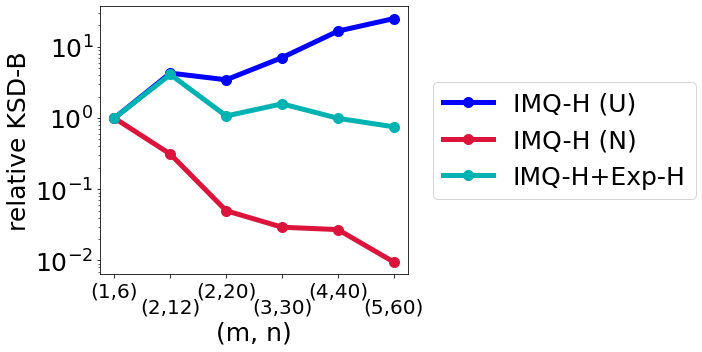

In [10]:
fig, ax = plt.subplots(1, figsize=[10, 5])

plt.semilogy(sf_ksds[0]/sf_ksds[0][0], color='blue', ls='-', lw=5,
             label='IMQ-H (U)', marker='.', markersize=20)
plt.semilogy(sf_ksds[1]/sf_ksds[1][0], color='crimson', ls='-', lw=5,
             label='IMQ-H (N)', marker='.', markersize=20)
plt.semilogy(vf_ksds[0]/vf_ksds[0][0], color=(0.0, 0.7, 0.7), ls='-', lw=5,
             label='IMQ-H+Exp-H', marker='.', markersize=20)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=25)

plt.xticks(np.arange(len(ns)), ['({},{})'.format(m, n) for n, m in zip(ns, ms)], fontsize=20)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(20)
plt.yticks(fontsize=25)
plt.xlabel("(m, n)", fontsize=25)
plt.ylabel("relative KSD-B", fontsize=25)
plt.tight_layout()

Thus $\mathrm{KSD-B}_{p, k}(q_{m, n})\to 0$ when $k$ is a normalized scalar field kernel, $\to\infty$ when $k$ is a tilted scalar field kernel, and plateaus when $k$ is a vector field kernel.
So, in this example, the scalar field KSD-B with a normalized kernel cannot detect non-convergence.

## Detecting convergence

In this example we consider a thick tailed $p\propto |X|^{-1.4}$ and $q_n(X)\propto p(X)1(|X|<n)$.
Clearly $q_{n}\to p$ as $n\to\infty$ but we show that as $n\to\infty$ we can have $\mathrm{KSD-B}_{p, k}(q_{n})\not\to 0$ if we use a unbounded scalar field kernel, rather than a vector field kernel or a bounded scalar field kernel.

Note
$$E_q\mathcal{T}_pf=\frac 1 2\sum_{(X, Y)\in M_{p, p}} p(Y)T_{p,Y\to X}\left(\frac{q(X)}{p(X)} -\frac{q(Y)}{p(Y)}\right)f(X, Y).$$
So we have
$$E_{q_L}\mathcal{T}_pf=q(L-1)T_{p,L-1\to L}f(L-1, L).$$
Thus,
$$\mathrm{KSD}_{p, k}(q_L)=q_L(L-1)^2T_{p,L-1\to L}^2k((L-1, L), (L-1, L)).$$
In this case, using $\chi(t)=1\wedge t$, $T_{p,L-1\to L}=L \frac{p(L)}{p(L-1)}$.

We will use this formula to calculate the $KSD-B$ for computational efficiency.

In [11]:
def ll_func(seqs, sig = 1.4):
    logs = - sig * np.log(get_lens(seqs)+1)
    logs[np.all(np.isnan(seqs[..., 0]), axis=-1)] = -np.inf
    return logs

In [12]:
kernel_ind = 0

ns = np.logspace(np.log10(3), np.log10(150), 20).astype(int)
sf_ksds = np.empty([len(kernels_list), len(ns)])
for j, (kern, tilt) in enumerate(zip(kernels_list, tilts)):
    for i, n in enumerate(ns):
        # get sequences in the support of q and calculate q(X)
        seqs = get_ohe([c * 'A' for c in np.arange(0, n)])[..., [0]]
        q = ll_func(seqs)
        q -= logsumexp(q)
        q = np.exp(q)
        
        # calculate the KSD-B
        seqs_l = get_ohe([c * 'A' for c in [n-1, n]])[..., [0]]
        t_p = ll_func(seqs_l)
        t_p = n * np.exp(t_p[-1] - t_p[0])
        k_mat = kern(seqs_l)
        tilt_vec = tilt(seqs_l)
        tilt_vec[1] *= -1
        cross_k = np.dot(tilt_vec, np.dot(k_mat, tilt_vec))

        sf_ksds[j, i] = (q[-1] * t_p)**2 * cross_k
        
vf_ksds = np.empty([len(vf_kernels_list), len(ns)])
for j, kern in enumerate(vf_kernels_list):
    for i, n in enumerate(ns):
        # get sequences in the support of q and calculate q(X)
        seqs = get_ohe([c * 'A' for c in np.arange(0, n)])[..., [0]]
        q = ll_func(seqs)
        q -= logsumexp(q)
        q = np.exp(q)
        
        # calculate the KSD-B
        seqs_l = get_ohe([c * 'A' for c in [n-1, n]])[..., [0]]
        t_p = ll_func(seqs_l)
        t_p = n * np.exp(t_p[-1] - t_p[0])
        cross_k = kern(seqs_l[None, 0], seqs_l[None, None, 1],
                       np.ones([1, 1]).astype(int))
        vf_ksds[j, i] = (q[-1] * t_p)**2 * cross_k

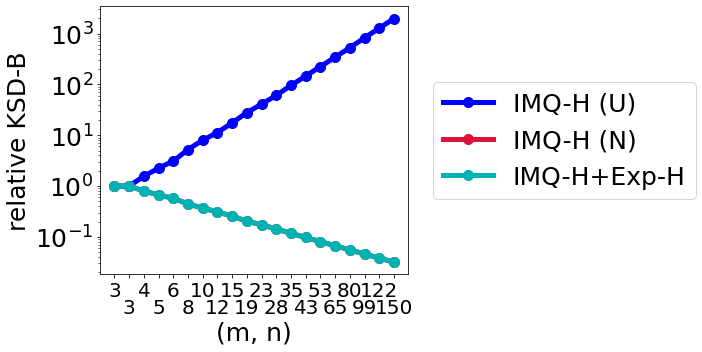

In [13]:
fig, ax = plt.subplots(1, figsize=[10, 5])

plt.semilogy(sf_ksds[0]/sf_ksds[0][0], color='blue', ls='-', lw=5,
             label='IMQ-H (U)', marker='.', markersize=20)
plt.semilogy(sf_ksds[1]/sf_ksds[1][0], color='crimson', ls='-', lw=5,
             label='IMQ-H (N)', marker='.', markersize=20)
plt.semilogy(vf_ksds[0]/vf_ksds[0][0], color=(0.0, 0.7, 0.7), ls='-', lw=5,
             label='IMQ-H+Exp-H', marker='.', markersize=20)

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=25)

plt.xticks(np.arange(len(ns)), ns, fontsize=20)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(20)
plt.yticks(fontsize=25)
plt.xlabel("(m, n)", fontsize=25)
plt.ylabel("relative KSD-B", fontsize=25)
plt.tight_layout()

In this example, $d_H(L-1, L)=1$ doesn't depend on $L$ so $𝑘((𝐿−1,𝐿),(𝐿−1,𝐿))$ is constant when $k=k^\nabla$ for the IMQ-H (N) scalar field kernel or when $k$ is the IMQ-H+Exp-H kernel. Thus, the KSD-Bs derived from these two kernels differ by a constant, so that they overlap in the above plot.

In conclusion, we find that $\text{KSD-B}_{p, k}(q_{(m, n)})$ converges to $0$ when $k$ is a normalized scalar field kernel or a vector field kernel, but converges to $\infty$ when $k$ is an unbounded scalar field kernel.

So, in this example, the unbounded scalar field kernel cannot detect convergence.